### Imports and API setup

In [3]:
import datetime
import json
import os
import dotenv

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from garminconnect import Garmin

# Load environment variables
dotenv.load_dotenv(".env", override=True)
EMAIL = os.getenv("EMAIL")
PASSWORD = os.getenv("PASSWORD")

assert EMAIL is not None, "EMAIL environment variable not defined"
assert PASSWORD is not None, "PASSWORD environment variable not defined"

/Users/tjp/Code/garmin-stats/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Setup API
api = Garmin(EMAIL, PASSWORD)
api.login()

Authenticating...


True

### Helper Functions

In [21]:
def json_to_file(data, filename: str):
    """Write JSON data to file."""
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)


def json_from_file(filename: str):
    """Load JSON data from file."""
    with open(filename, "r") as f:
        return json.load(f)


def json_to_str(data):
    """Convert JSON data to string."""
    return json.dumps(data, indent=4)


def ms_to_date(ms: int):
    """Convert epoch timestamp in milliseconds to datetime object."""
    return datetime.datetime.fromtimestamp(ms / 1000.0)

### Querying data

In [18]:
# Example selections and settings
TODAY = datetime.date.today()
YESTERDAY = TODAY - datetime.timedelta(days=1)
WEEK_AGO = TODAY - datetime.timedelta(days=7)
MONTH_AGO = TODAY - datetime.timedelta(days=30)
YEAR_AGO = TODAY - datetime.timedelta(days=365)

FOUR_YEARS_AGO = TODAY - datetime.timedelta(days=365*4)

In [19]:
def save_hr_data(day: datetime.date):
    """Save heart rate data for a given day"""
    day_iso = day.isoformat()
    filename = f'data/hr/{day_iso}.json'
    if os.path.isfile(filename):
        # Skip if file already exists
        return

    sleep = api.get_heart_rates(day_iso)
    json_to_file(sleep, filename)


def save_stress_data(day: datetime.date):
    """Save stress data for a given day"""
    day_iso = day.isoformat()
    filename = f'data/stress/{day_iso}.json'
    if os.path.isfile(filename):
        # Skip if file already exists
        return

    stress = api.get_stress_data(day_iso)
    json_to_file(stress, filename)


def save_sleep_data(day: datetime.date):
    """Save sleep data for a given day to a file"""
    day_iso = day.isoformat()
    filename = f'data/sleep/{day_iso}.json'
    if os.path.isfile(filename):
        # Skip if file already exists
        return

    sleep = api.get_sleep_data(day_iso)
    json_to_file(sleep, filename)


def save_stats_data(day: datetime.date):
    """Save stats data for a given day to a file"""
    day_iso = day.isoformat()
    filename = f'data/stats/{day_iso}.json'
    if os.path.isfile(filename):
        # Skip if file already exists
        return

    stats = api.get_stats(day_iso)
    json_to_file(stats, filename)

In [ ]:
# Pull from API

i = 0
day = FOUR_YEARS_AGO

while day < TODAY:
    save_sleep_data(day)
    save_stats_data(day)

    # Go to next day
    day = day + datetime.timedelta(days=1)
    i = i + 1

    # Print progress
    if i % 100 == 0:
        print(f"Day {i} - {day.isoformat()}")

### Data Analysis

In [22]:
stats_list = []
sleep_list = []

day = FOUR_YEARS_AGO
while day < TODAY:
    day_iso = day.isoformat()

    stats_json = json_from_file(f"data/stats/{day_iso}.json")
    stats_list.append(stats_json)

    sleep_json = json_from_file(f"data/sleep/{day_iso}.json")
    sleep_list.append(sleep_json["dailySleepDTO"])
    
    day += datetime.timedelta(days=1)

raw_df = pd.DataFrame(stats_list)
raw_df = pd.merge(raw_df, pd.DataFrame(sleep_list), on="calendarDate")

In [55]:
# Get data we care about
df = pd.DataFrame()
df["date"] = pd.to_datetime(raw_df["calendarDate"])
df["daySinceEpoch"] = (df["date"] - datetime.datetime(1970,1,1)).dt.days
df["dayOfWeek"] = df["date"].dt.dayofweek

# Add sleep data
df["sleepTimeHours"] = raw_df["sleepTimeSeconds"] / 3600

df["deepSleepHours"] = raw_df["deepSleepSeconds"] / 3600
df["lightSleepHours"] = raw_df["lightSleepSeconds"] / 3600
df["remSleepHours"] = raw_df["remSleepSeconds"] / 3600
df["awakeSleepHours"] = raw_df["awakeSleepSeconds"] / 3600

df["deepSleepPercent"] = raw_df["deepSleepSeconds"] / raw_df["sleepTimeSeconds"]
df["lightSleepPercent"] = raw_df["lightSleepSeconds"] / raw_df["sleepTimeSeconds"]
df["remSleepPercent"] = raw_df["remSleepSeconds"] / raw_df["sleepTimeSeconds"]
df["awakeSleepPercent"] = raw_df["awakeSleepSeconds"] / raw_df["sleepTimeSeconds"]

# HR attributes
hr_attrs = [
    "restingHeartRate", 
    "maxHeartRate", 
    "minHeartRate",
    # "minAvgHeartRate", 
    # "maxAvgHeartRate",
]

# Stress attributes
stress_attrs = [
    "averageStressLevel", 
    "maxStressLevel", 
    "stressPercentage",
    "restStressPercentage",
    "activityStressPercentage",
    # "uncategorizedStressPercentage",
    "lowStressPercentage",
    "mediumStressPercentage",
    "highStressPercentage",
    "stressQualifier",
]

# Activity attributes
df["activeHours"] = raw_df["activeSeconds"] / 3600
df["sedentaryHours"] = raw_df["sedentarySeconds"] / 3600

activity_attrs = [
    "totalSteps",
    "totalKilocalories",
    "activeKilocalories",
    "moderateIntensityMinutes",
    "vigorousIntensityMinutes",
    "avgWakingRespirationValue",
    # "highestRespirationValue",
    # "lowestRespirationValue",
    "bodyBatteryChargedValue",
    "bodyBatteryDrainedValue",
    "bodyBatteryHighestValue",
    "bodyBatteryLowestValue",
]

for attr in hr_attrs + stress_attrs + activity_attrs:
    df[attr] = raw_df[attr]

In [56]:
# Save to CSV
df.to_csv('data/garmin.csv')

In [57]:
# Load from CSV
df = pd.read_csv('data/garmin.csv', parse_dates=True)

<Axes: >

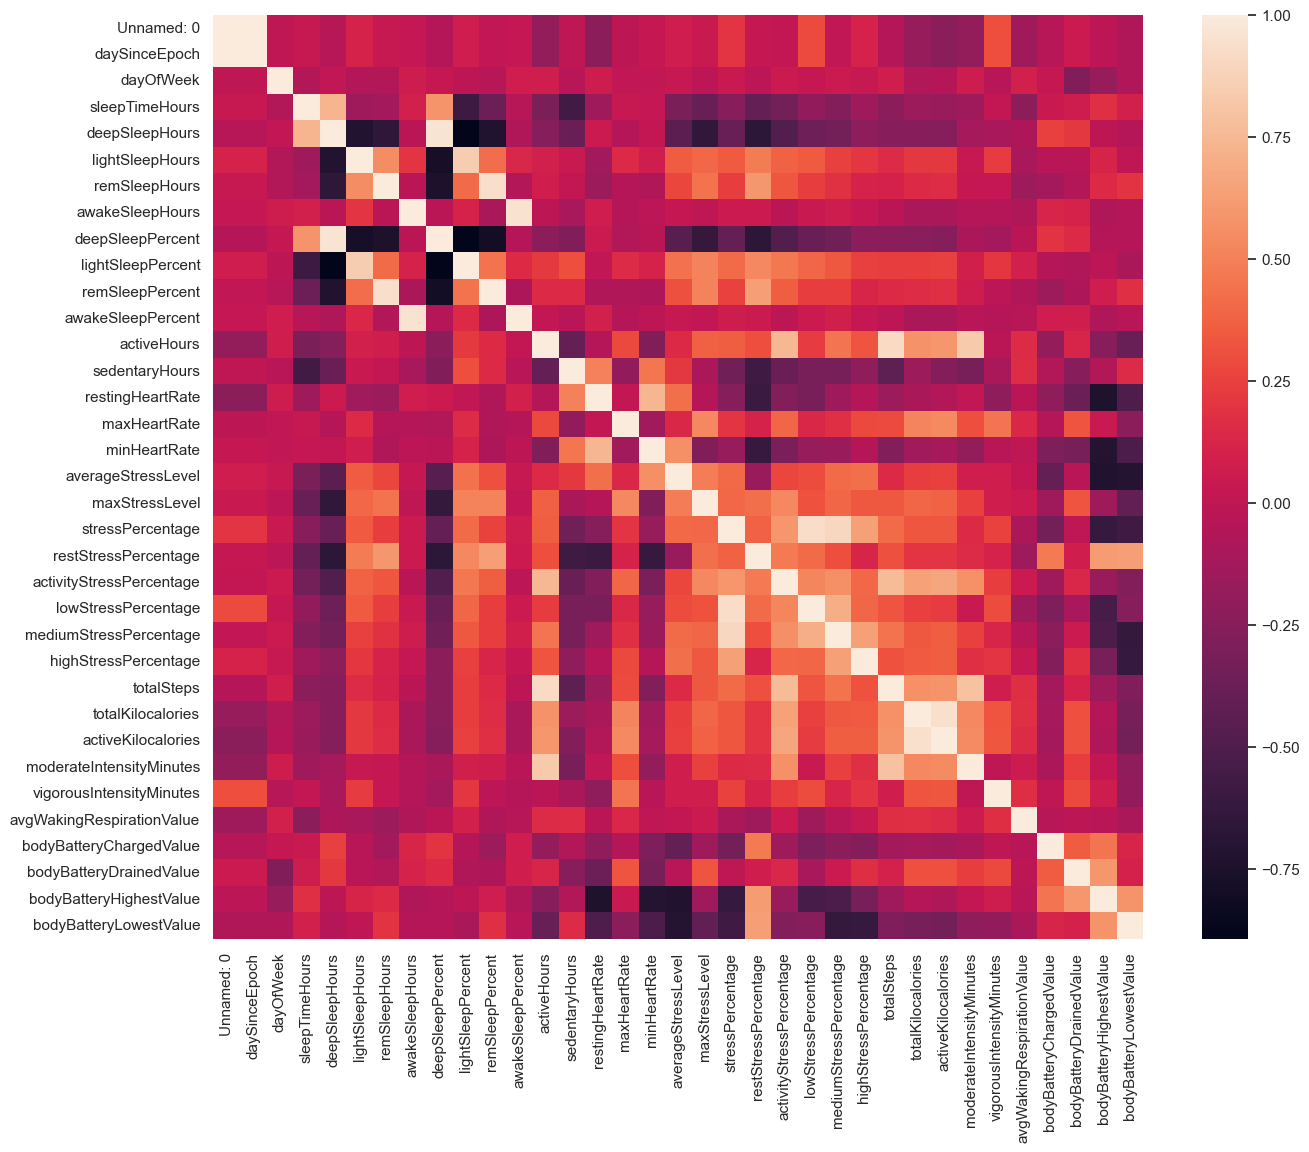

In [61]:
# All correlation heat map
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(numeric_only=True))

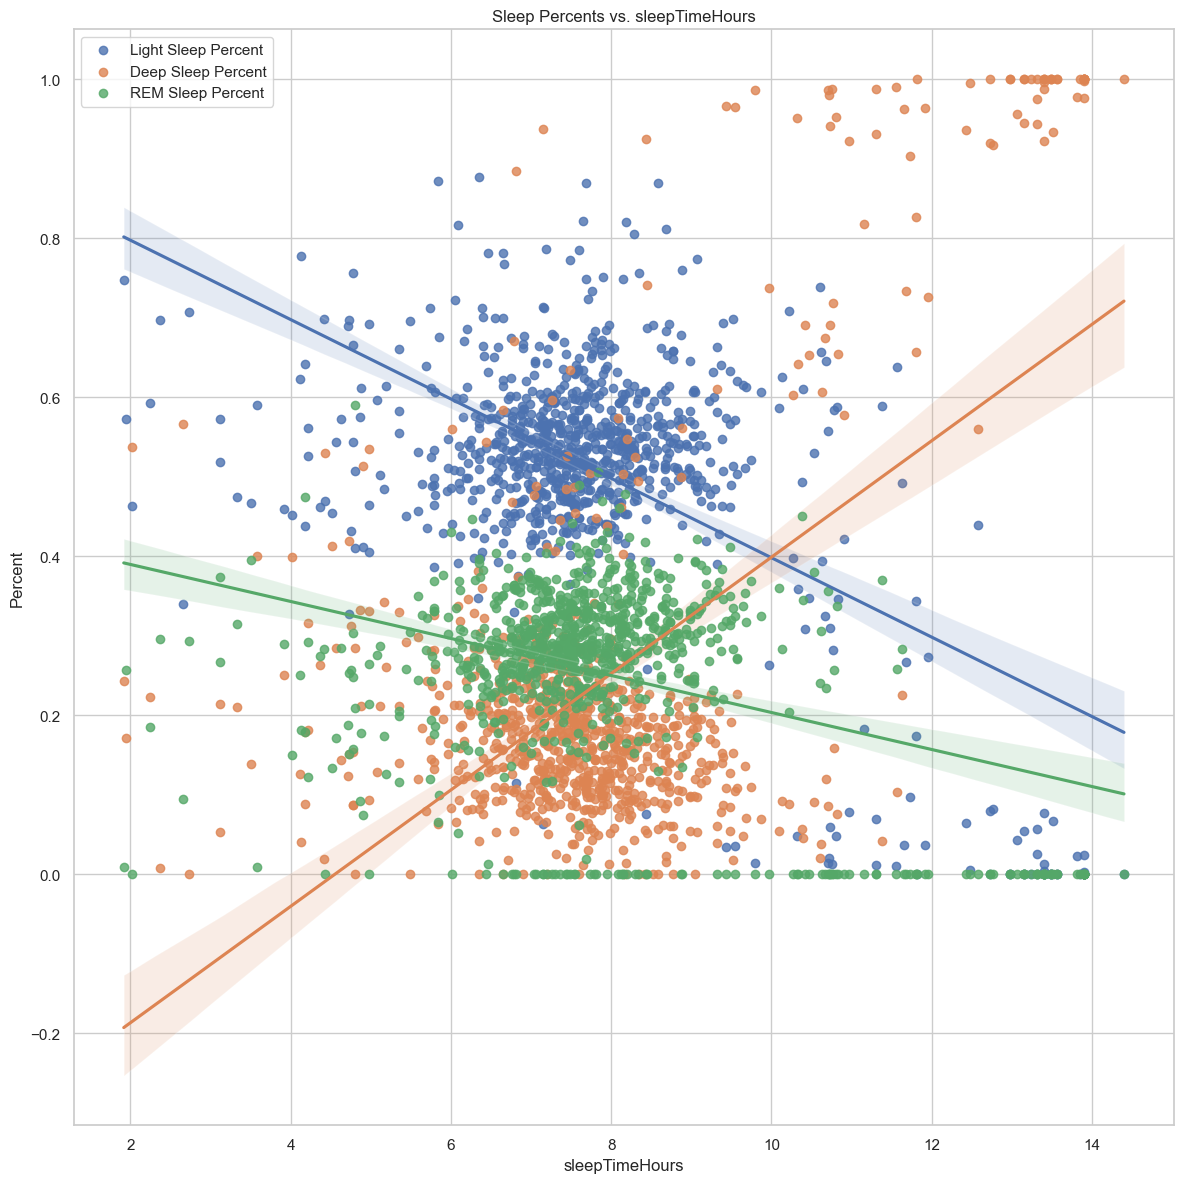

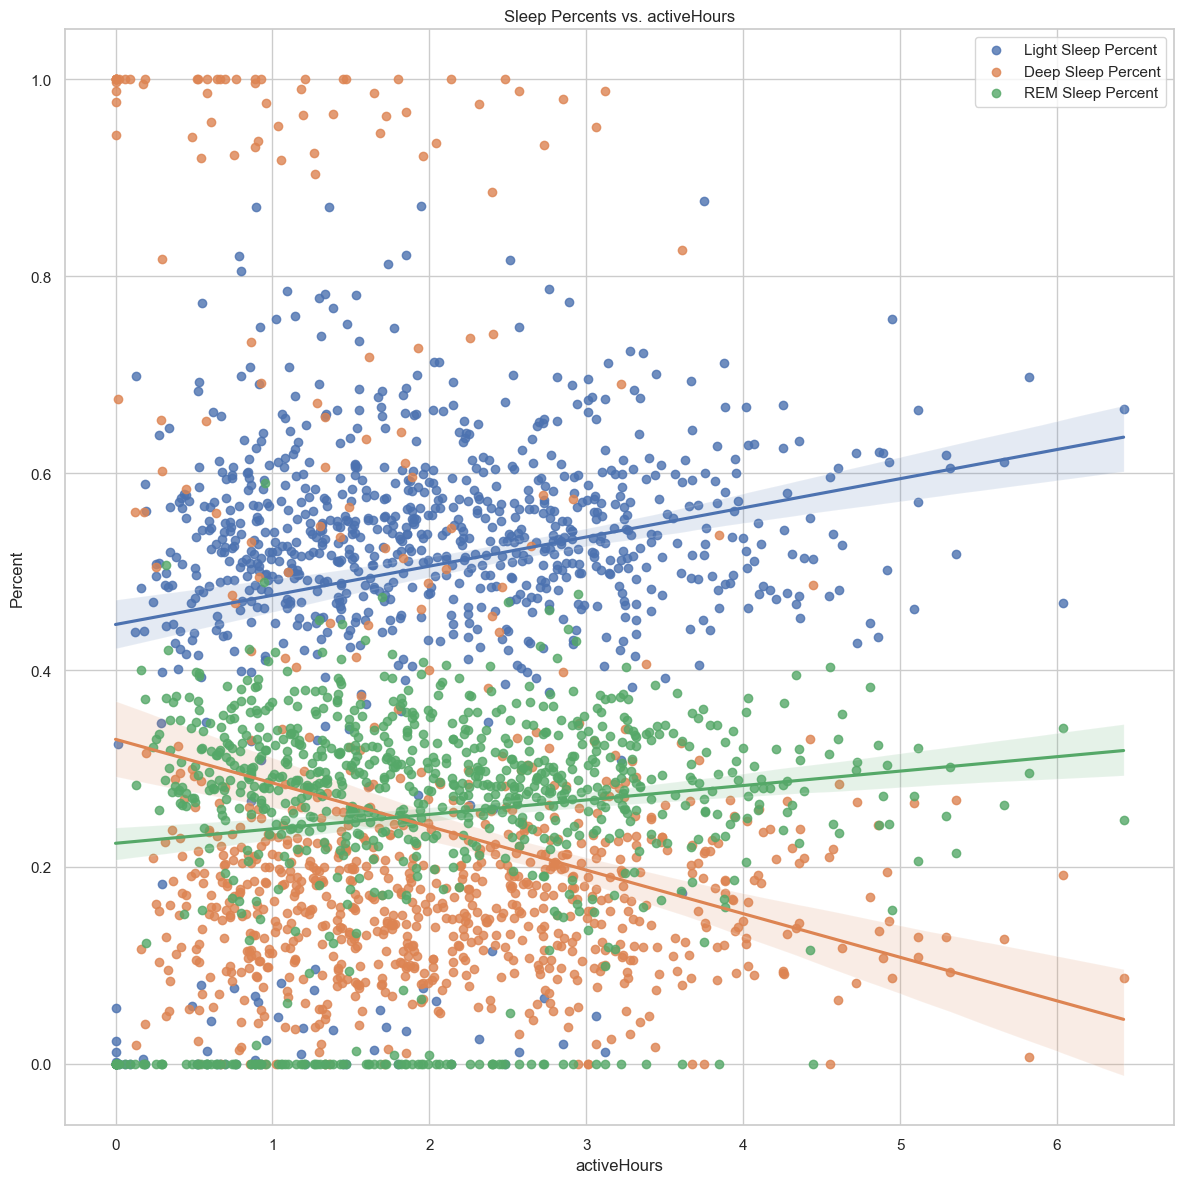

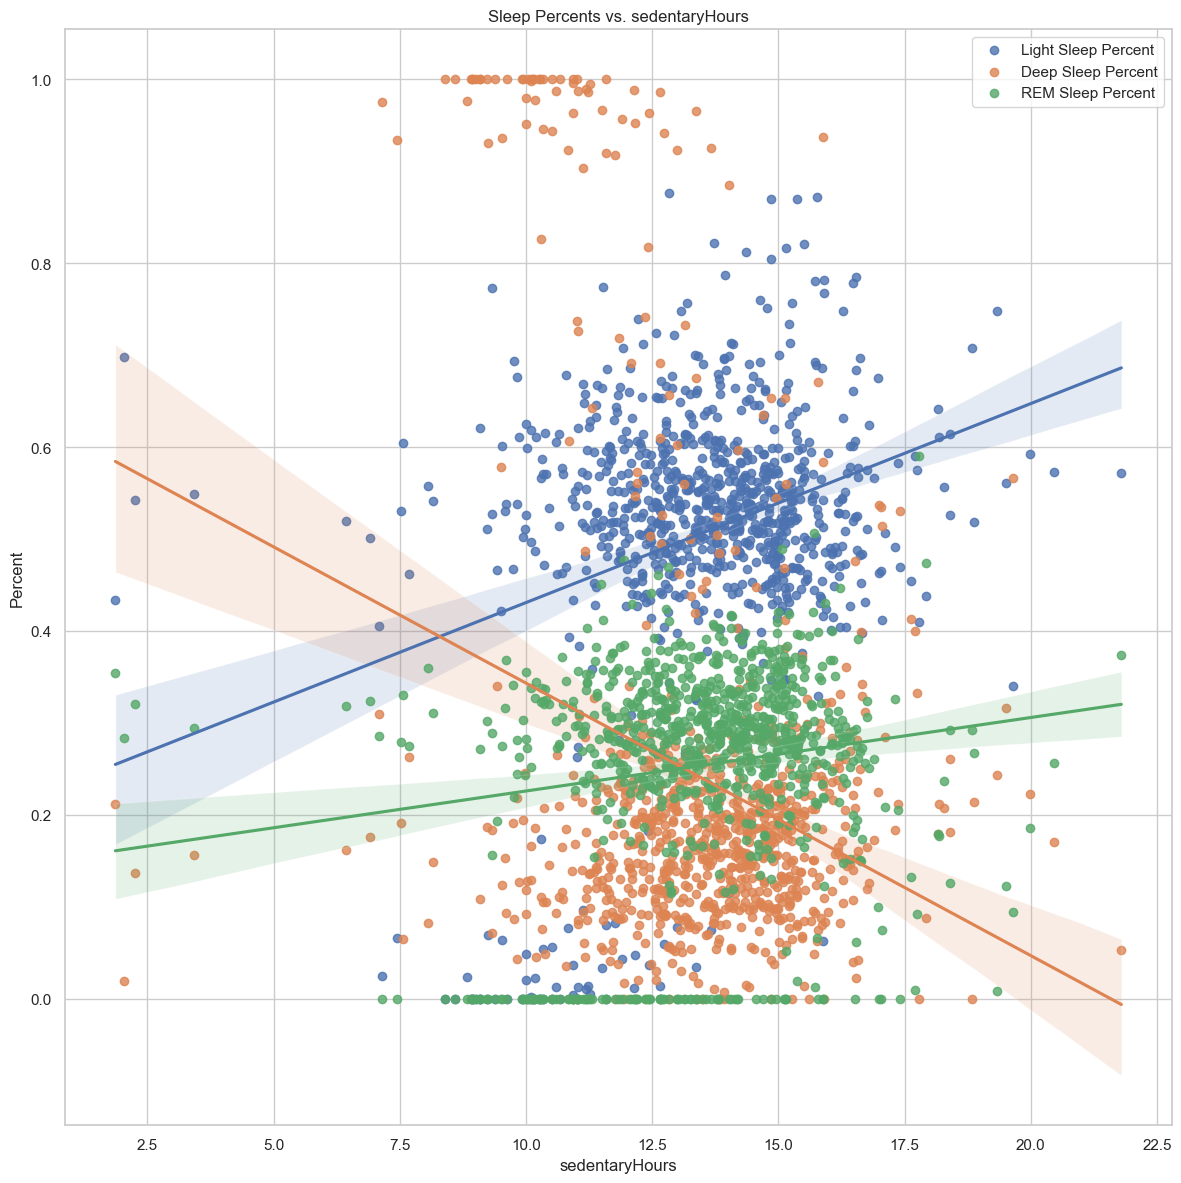

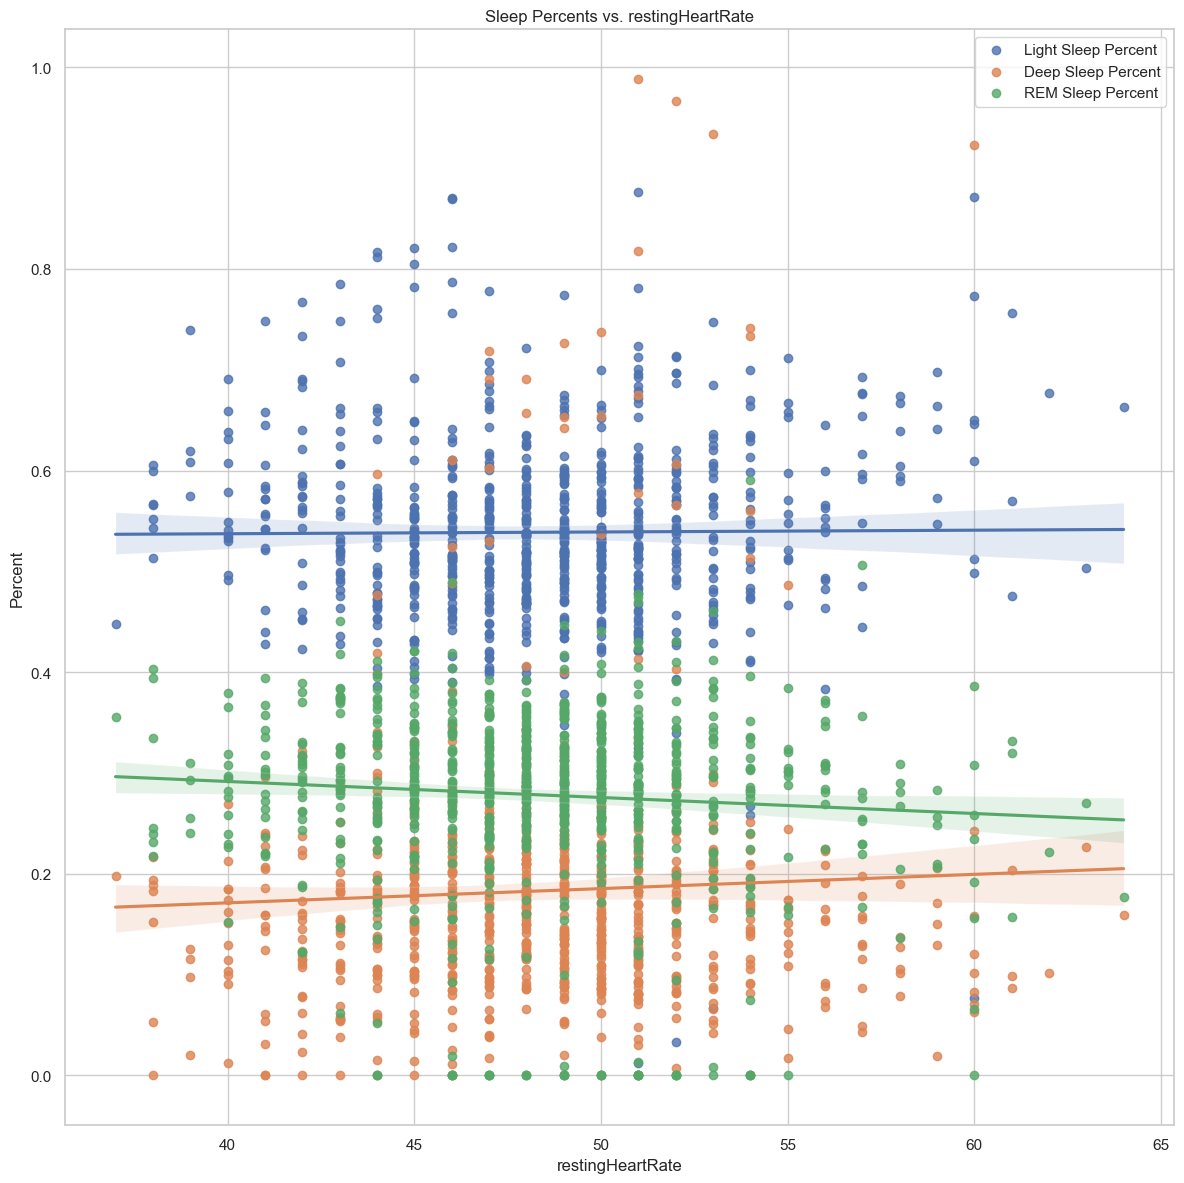

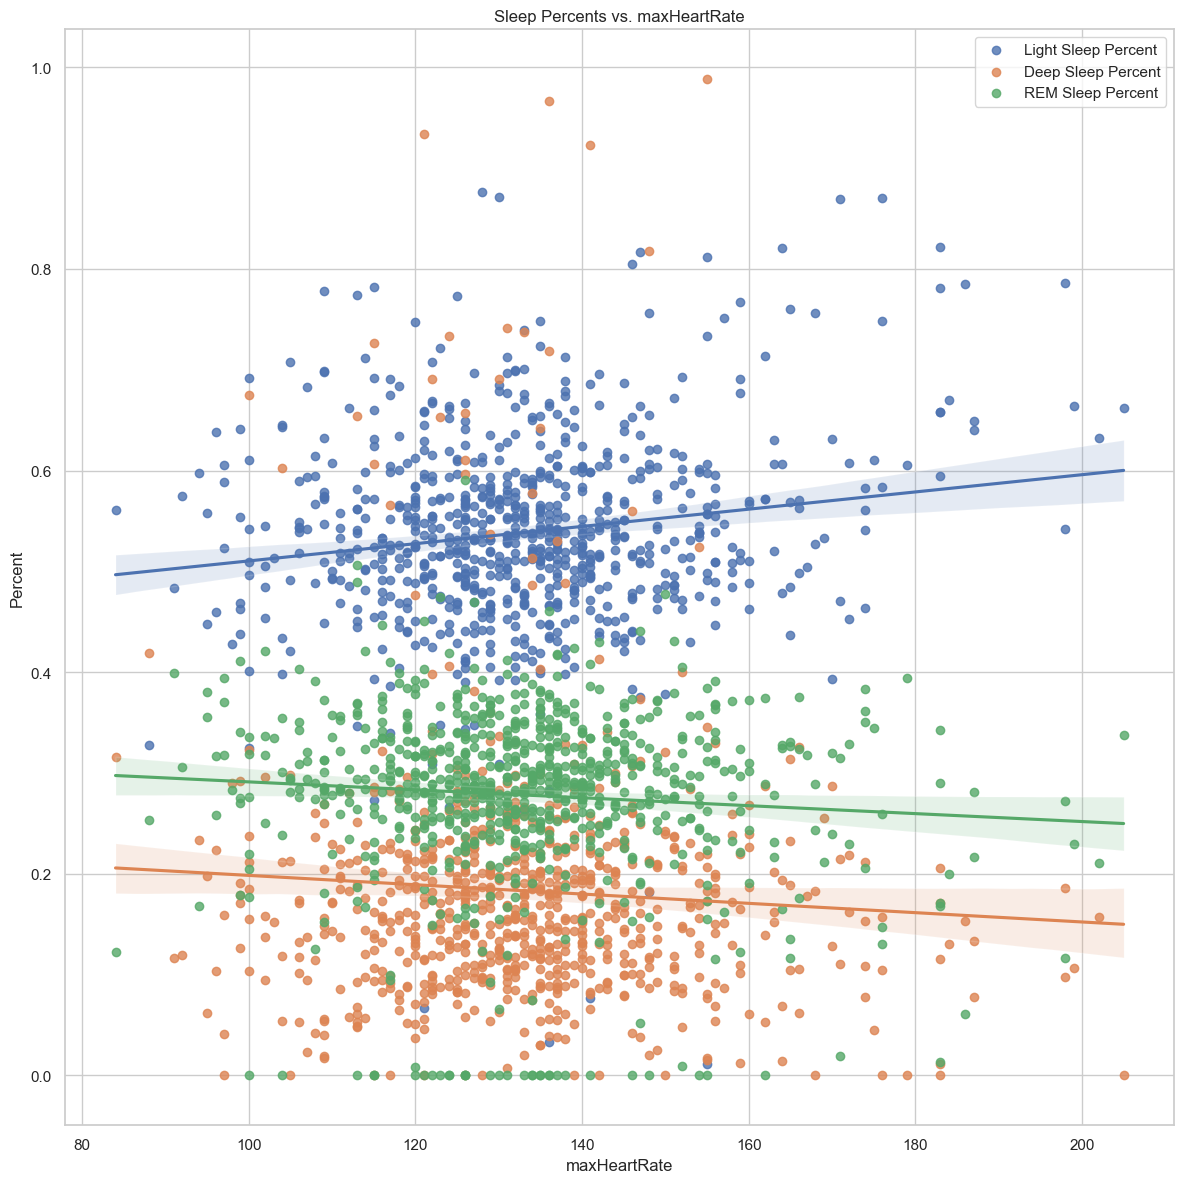

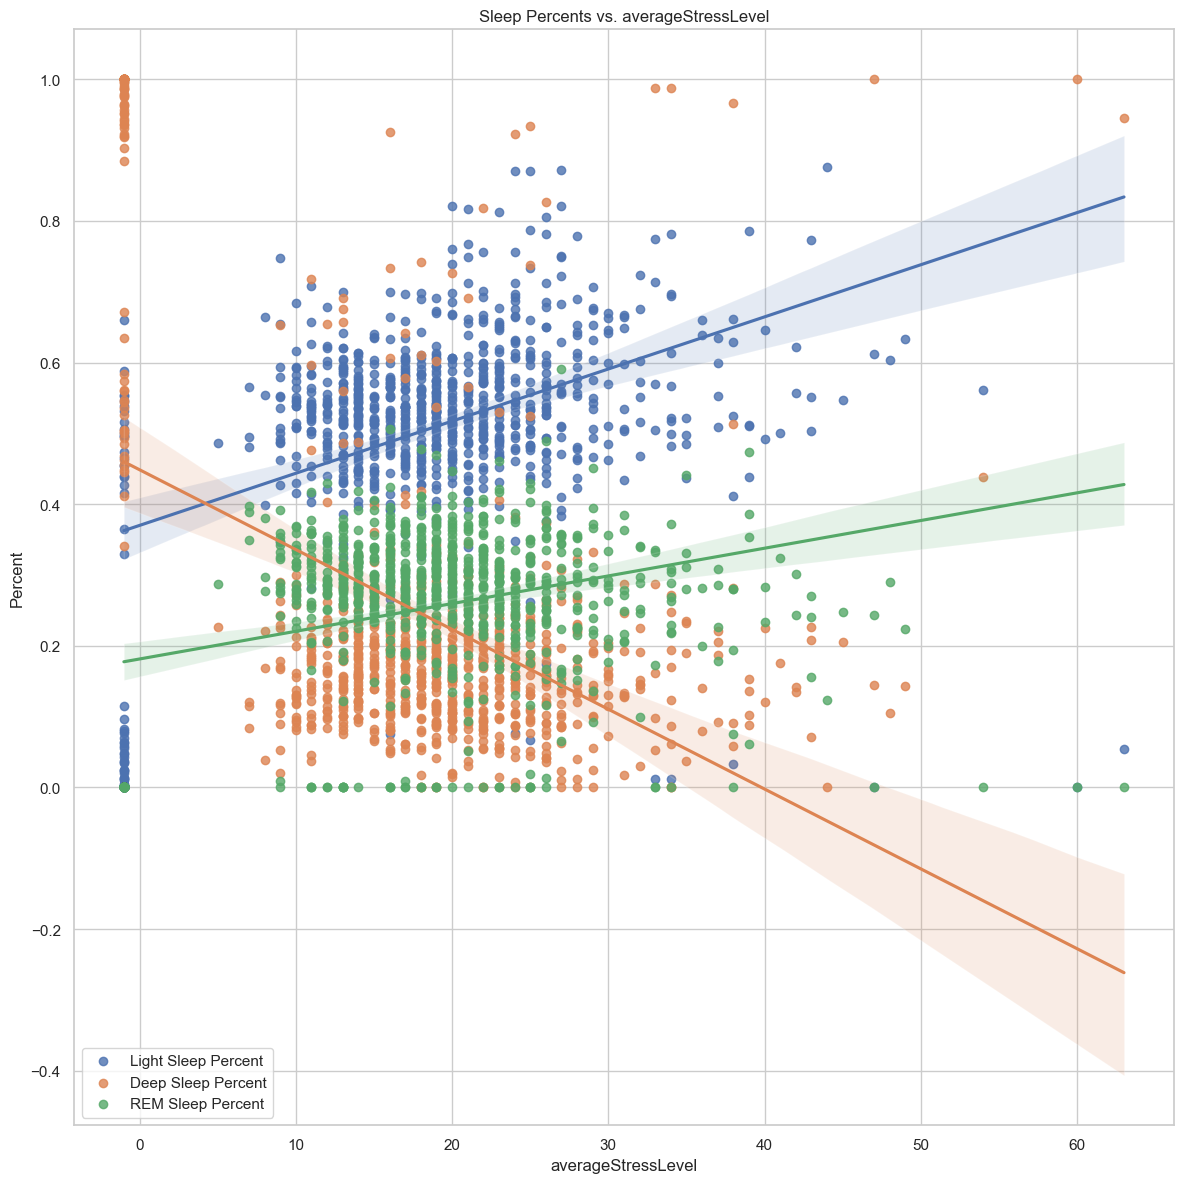

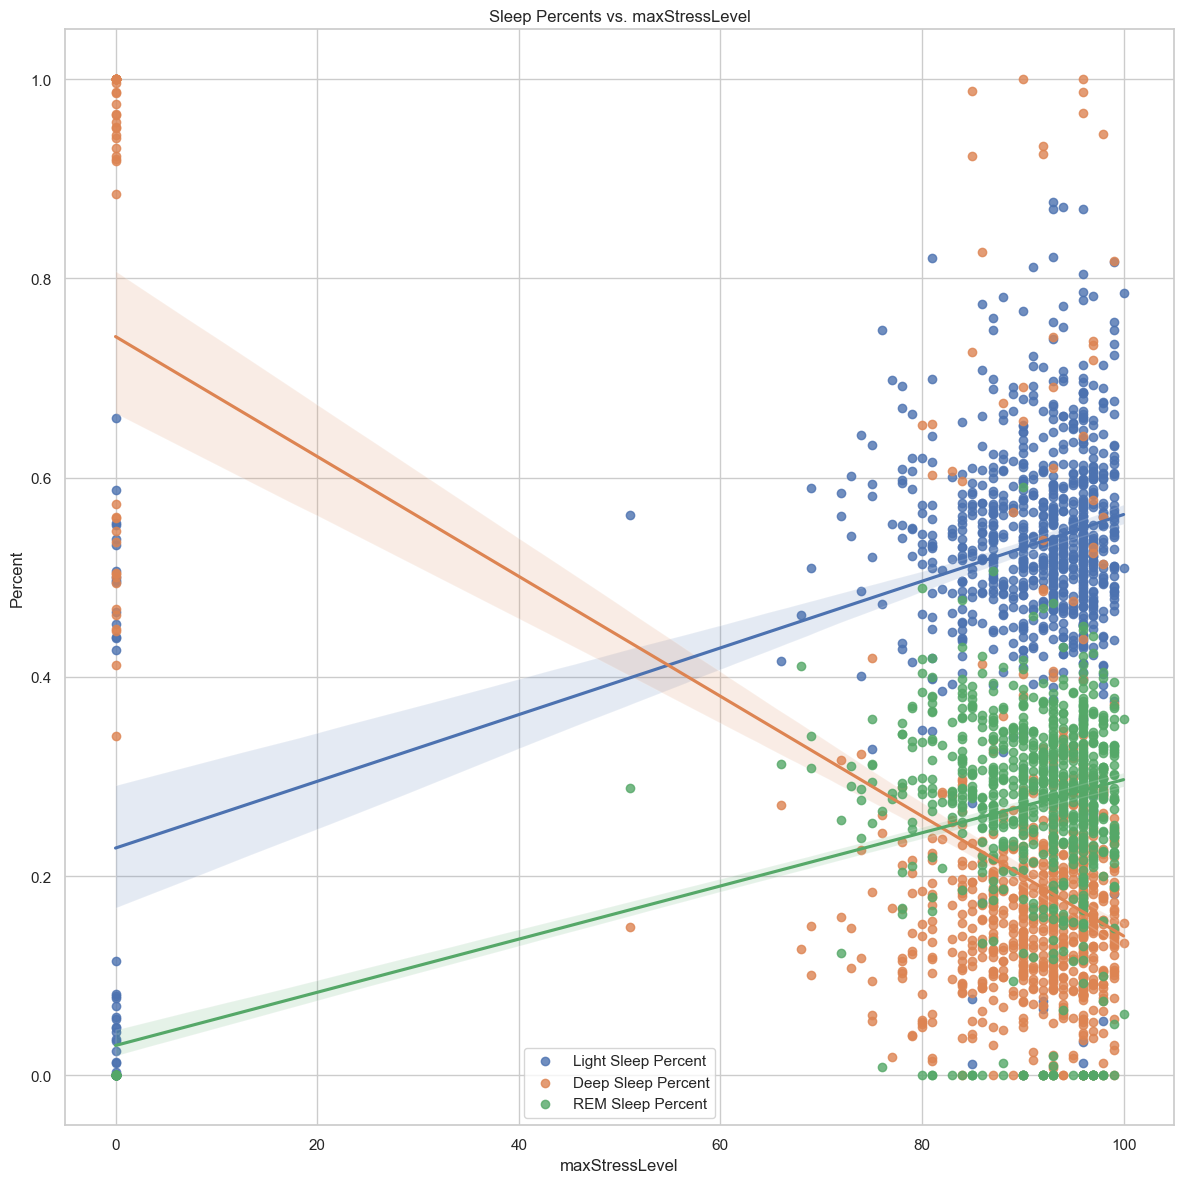

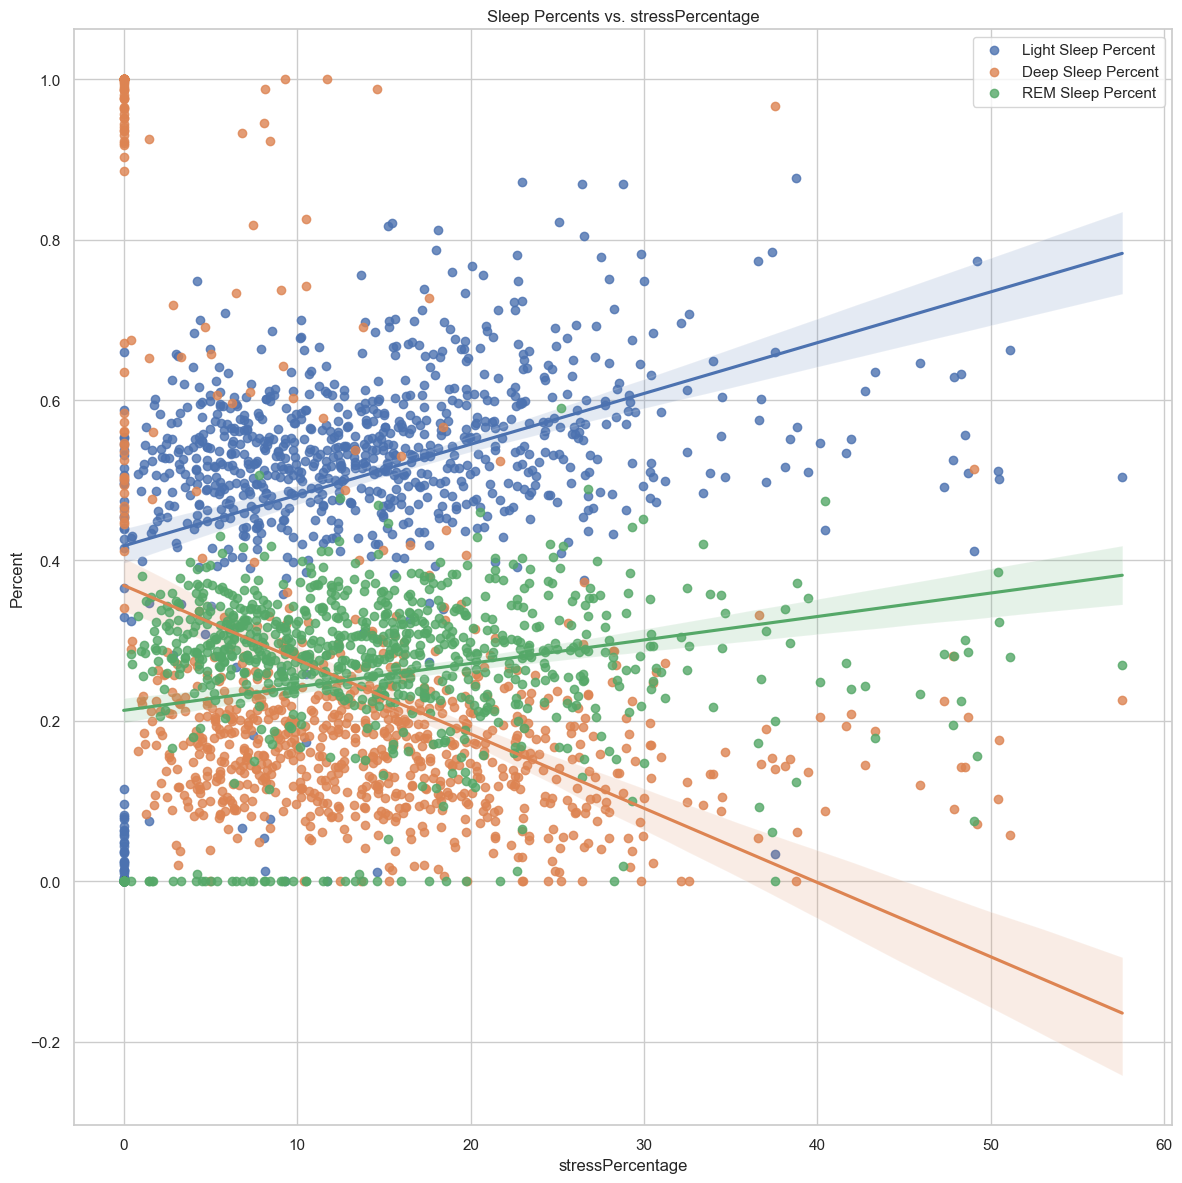

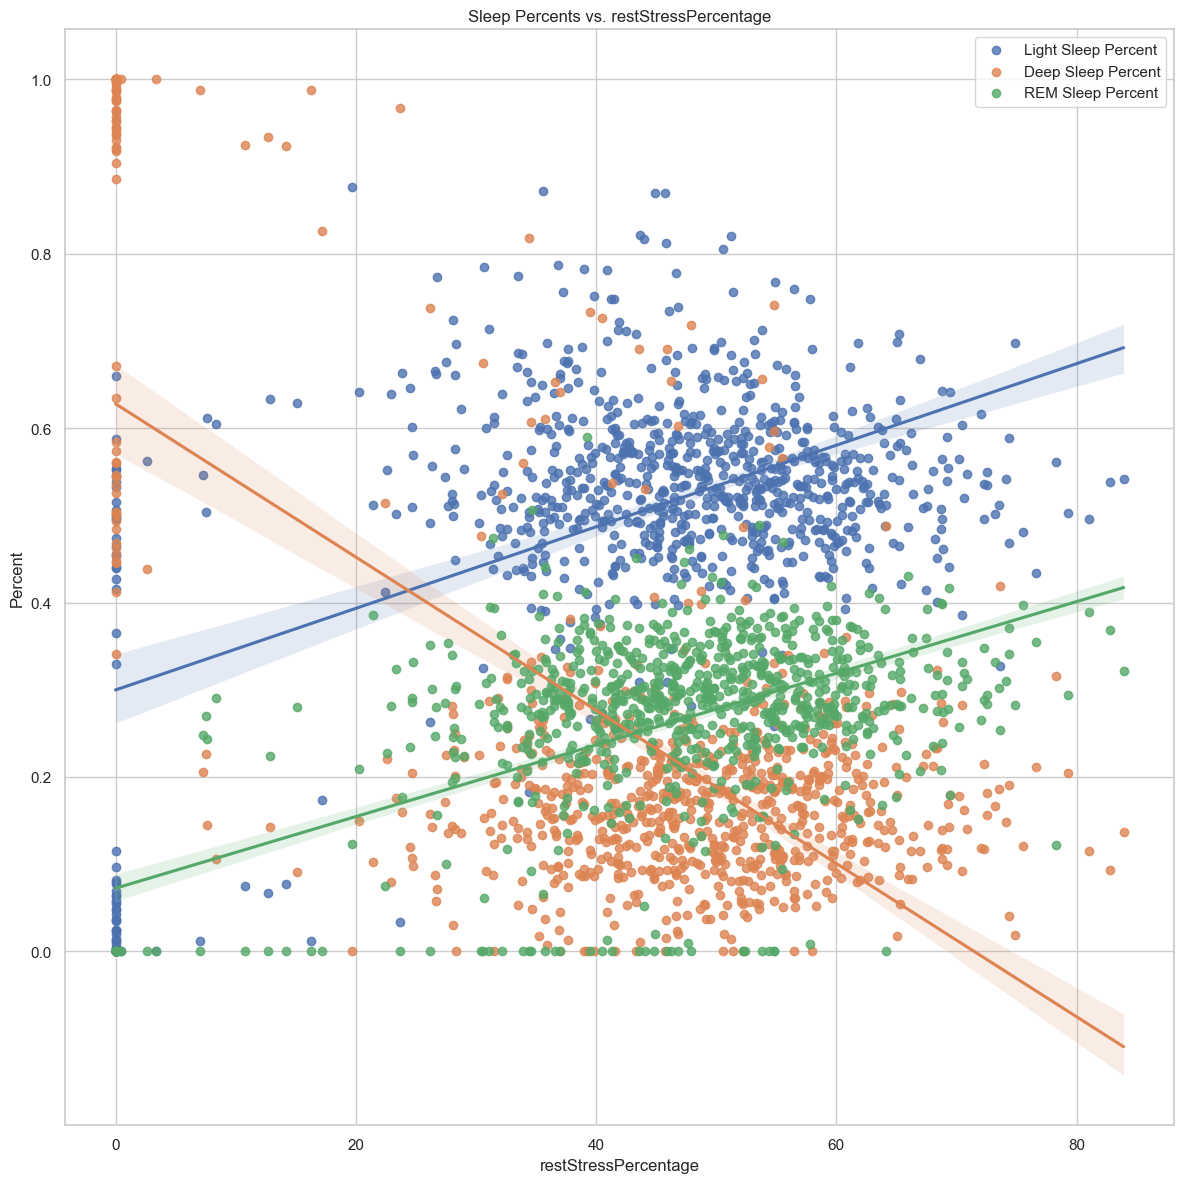

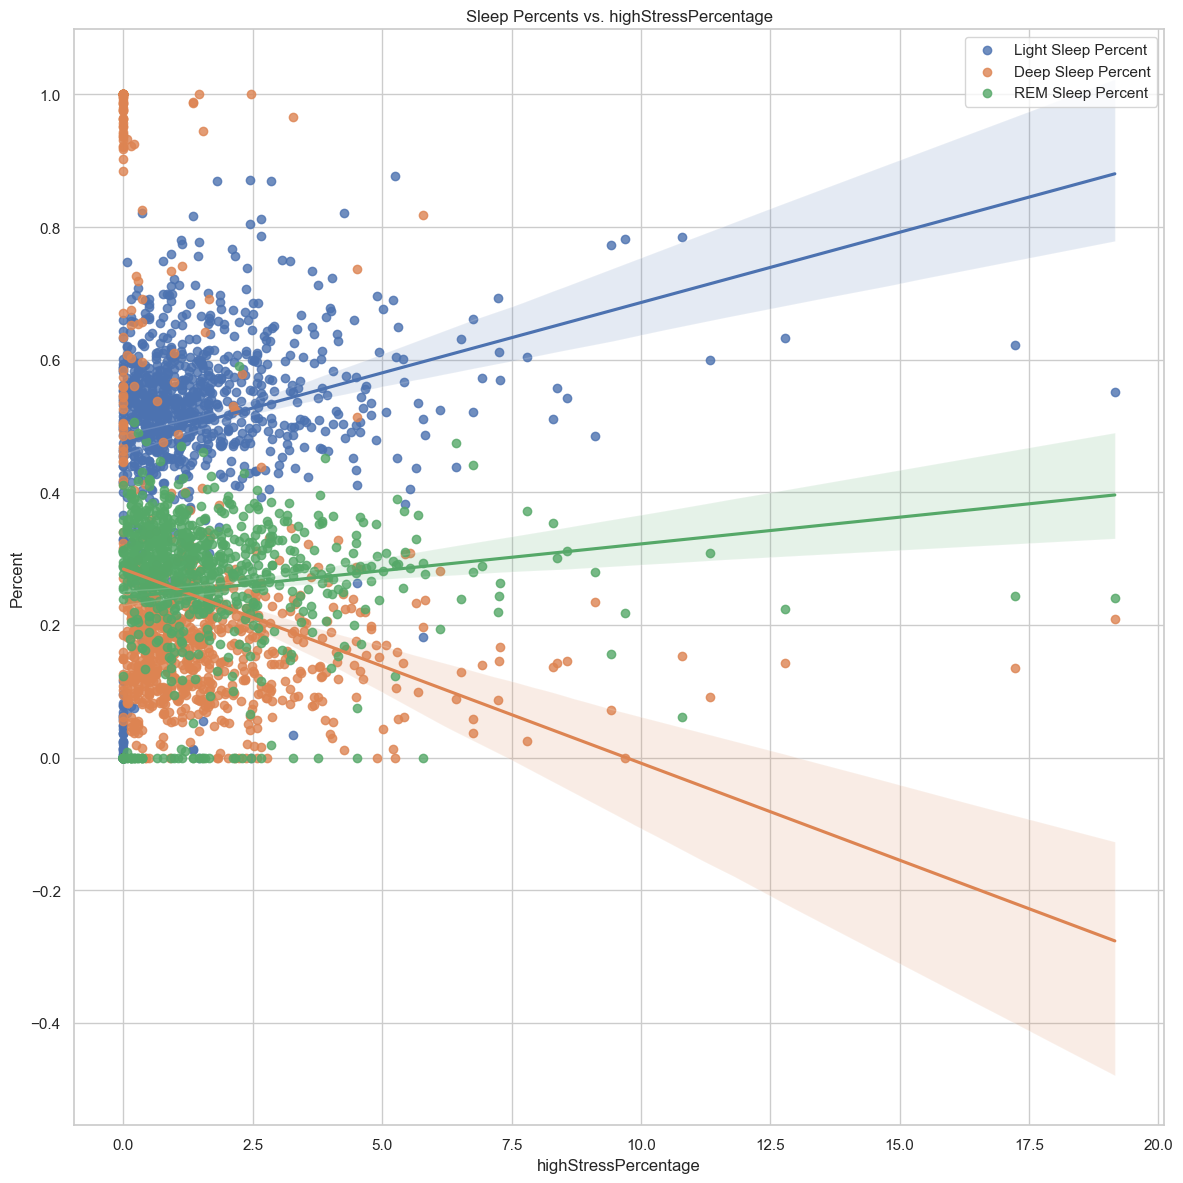

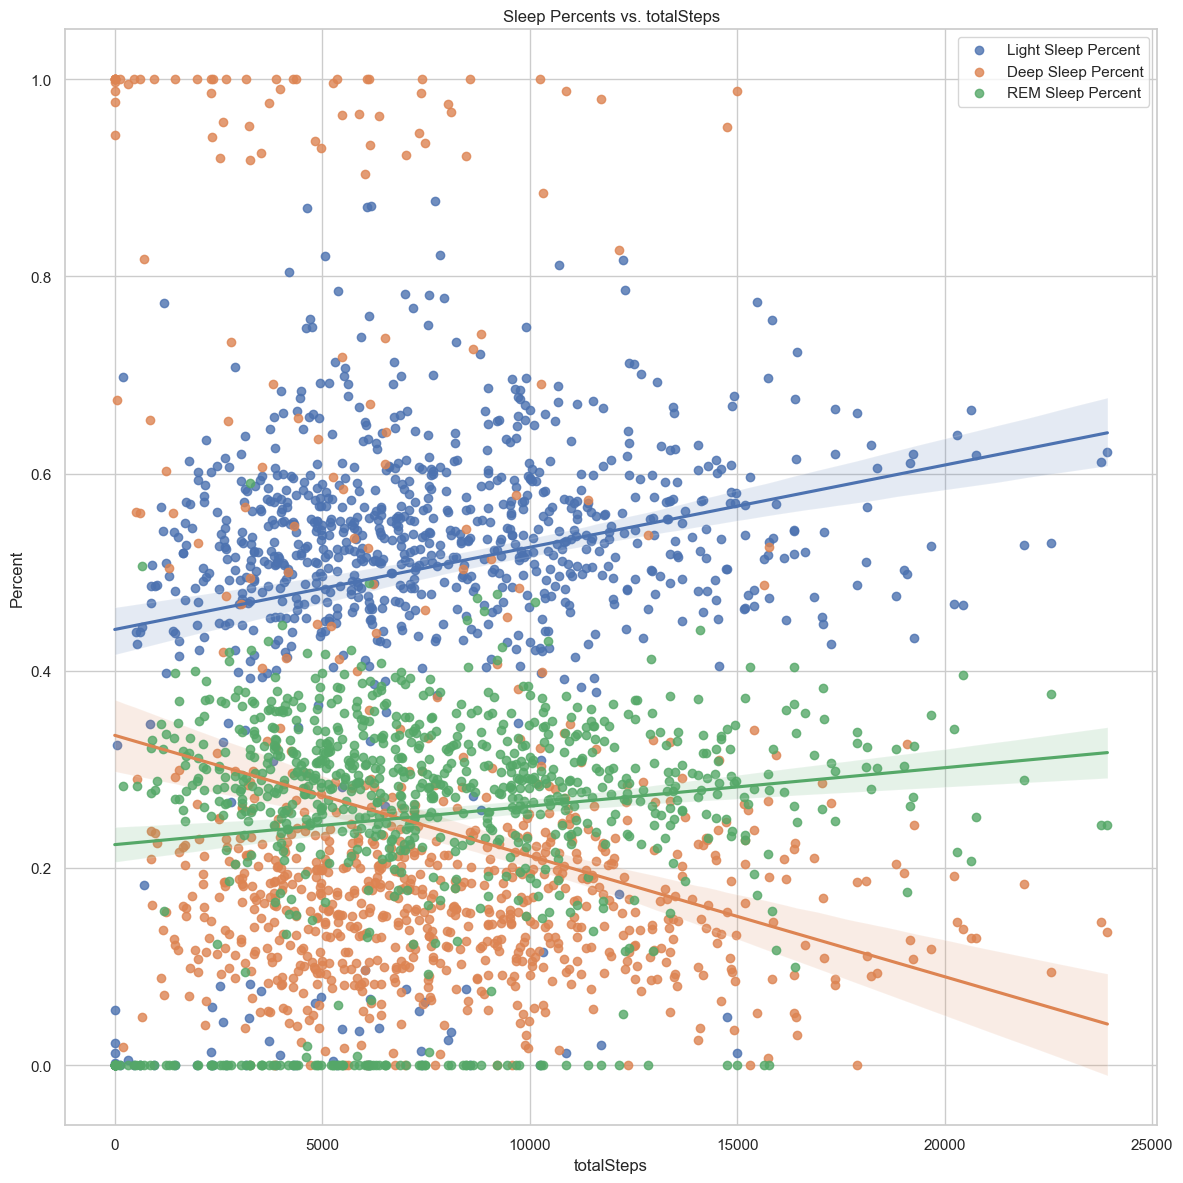

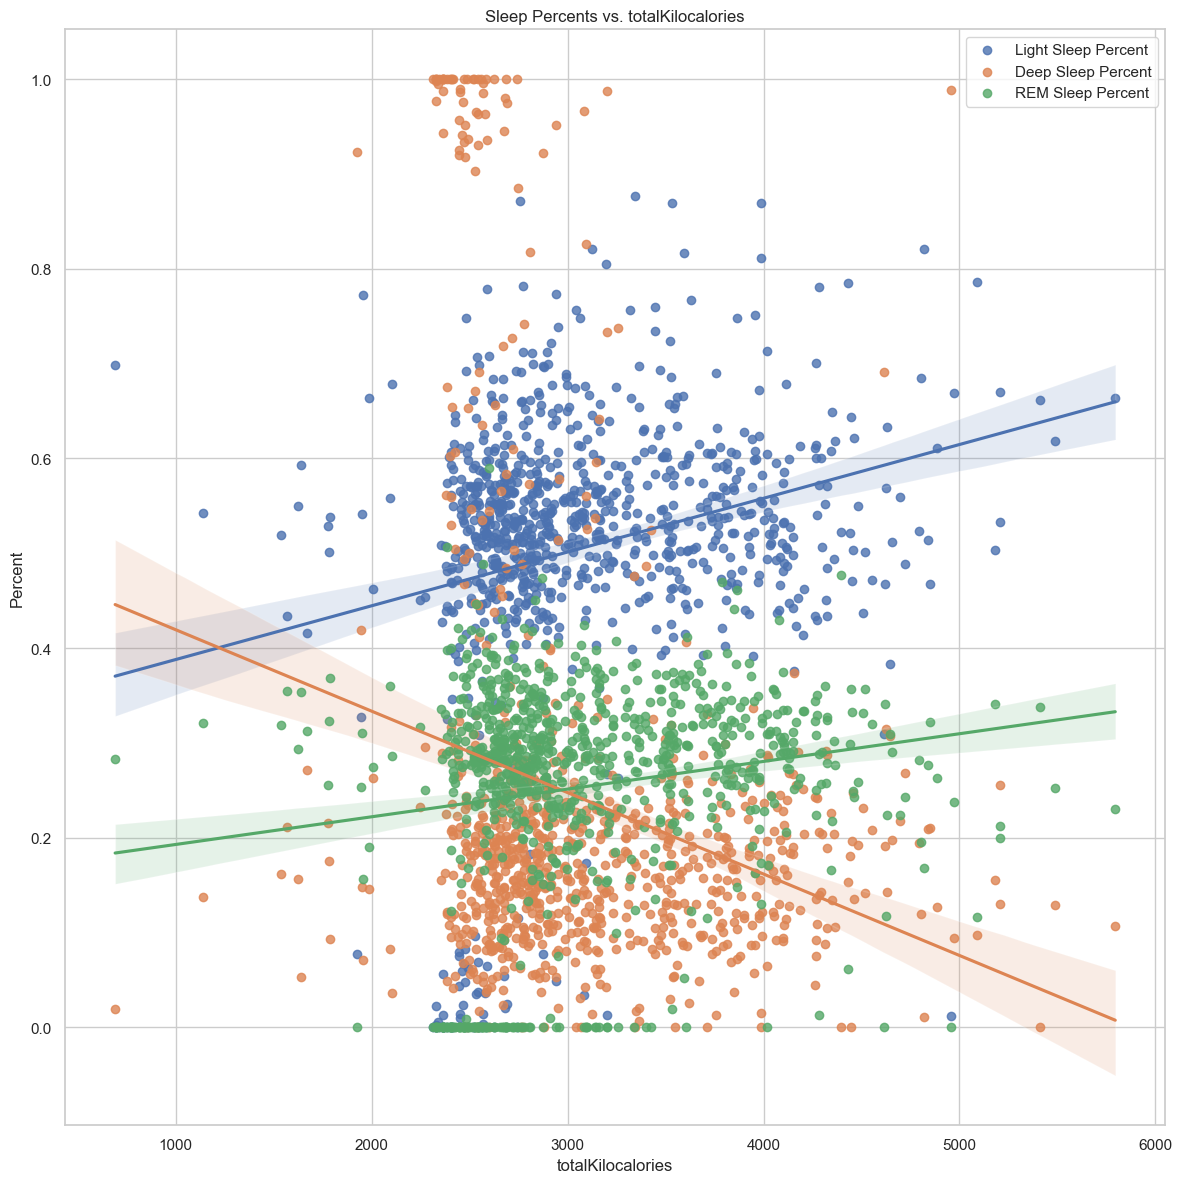

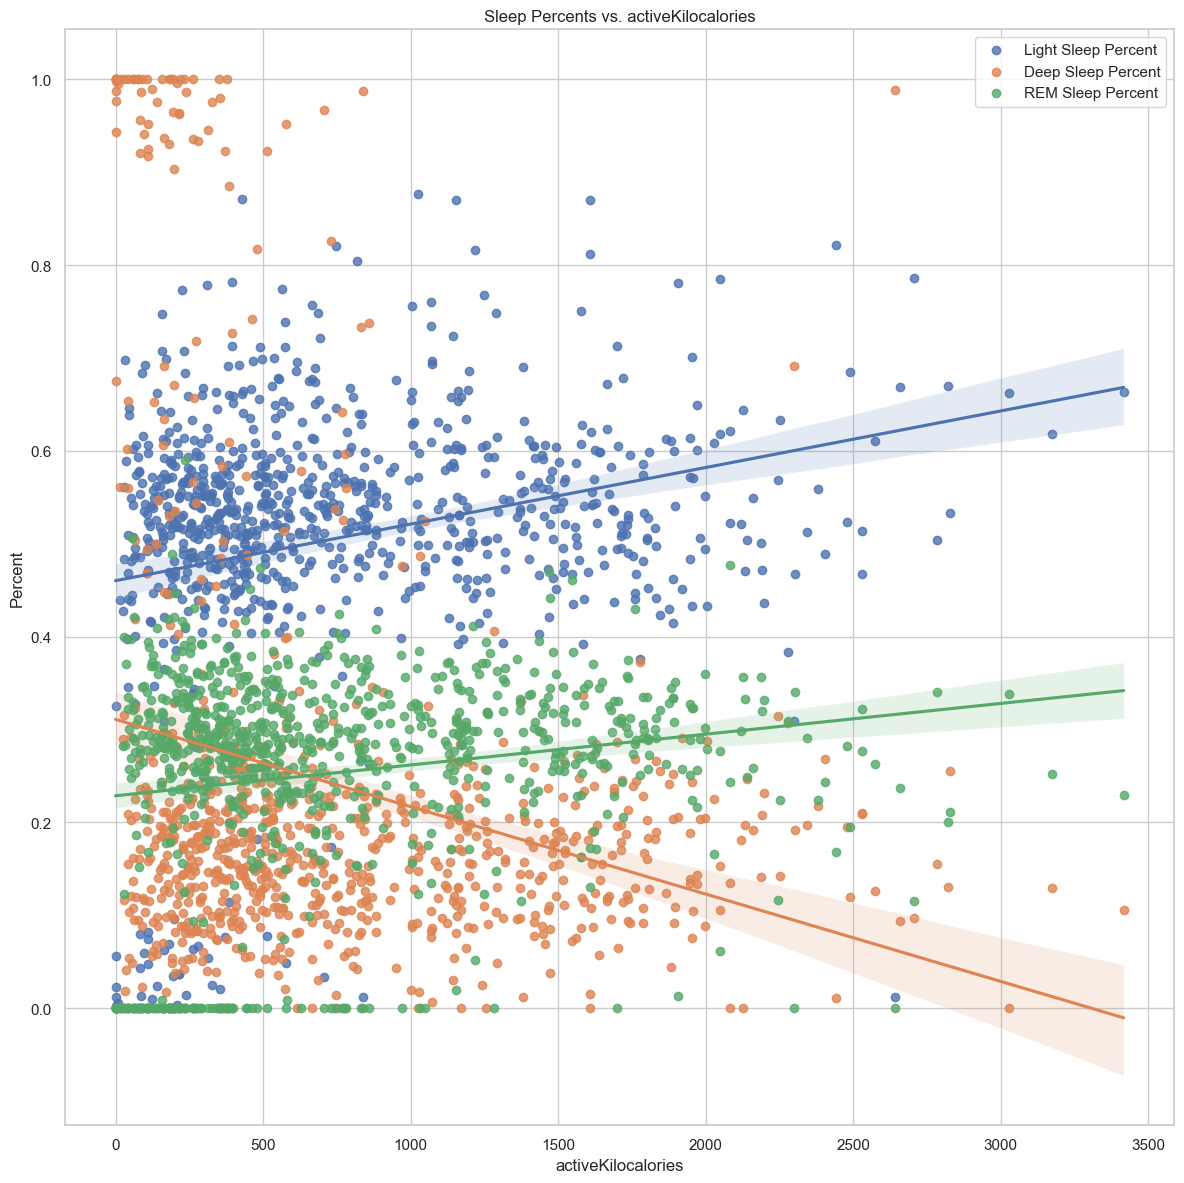

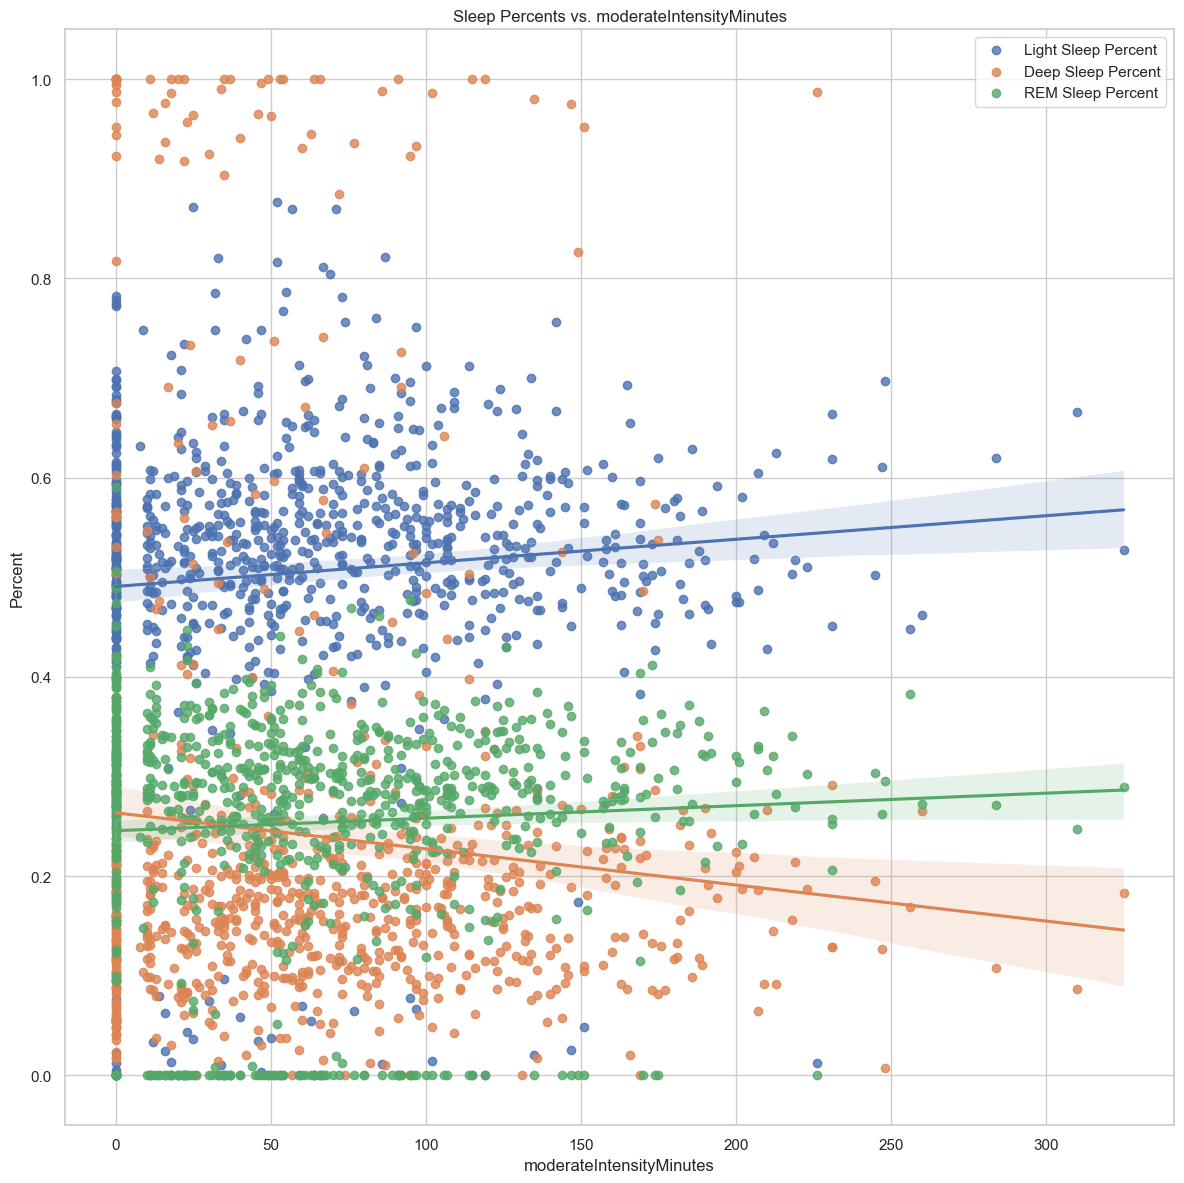

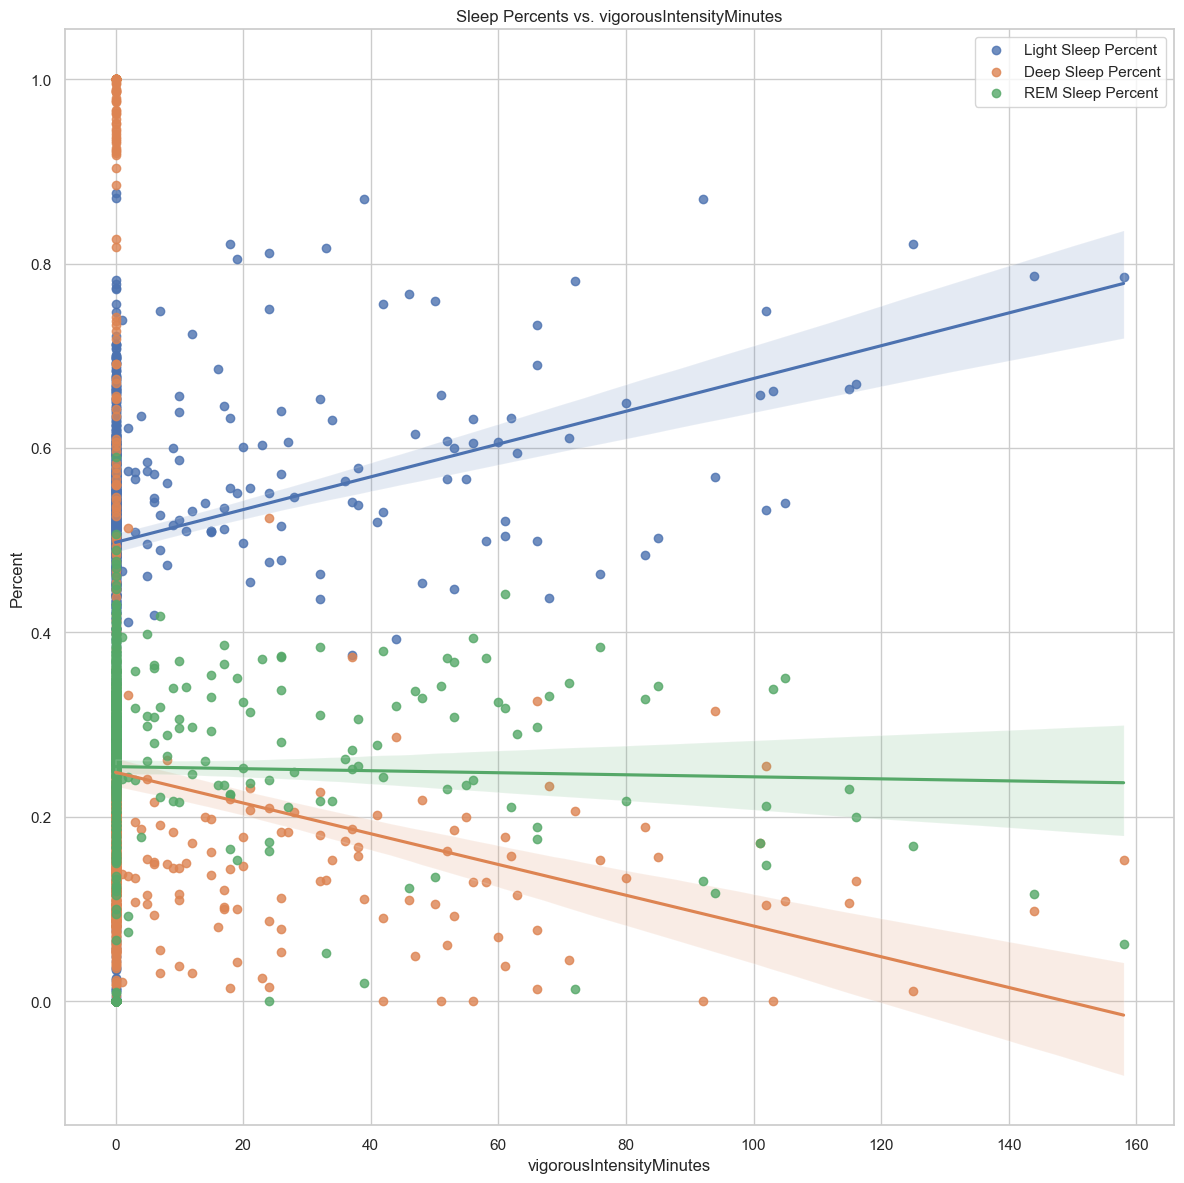

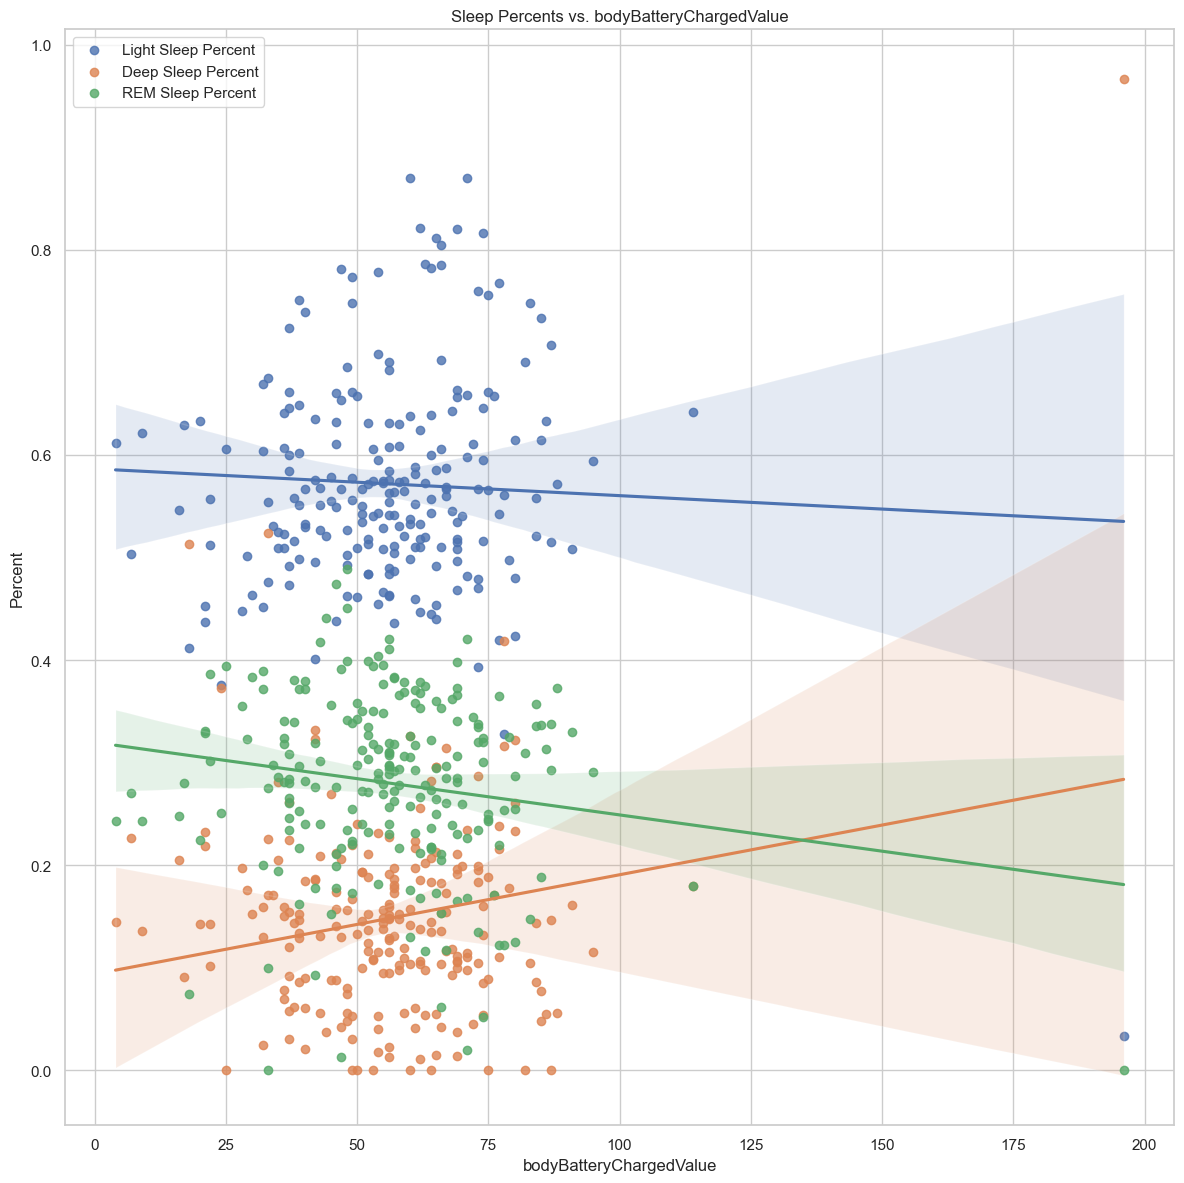

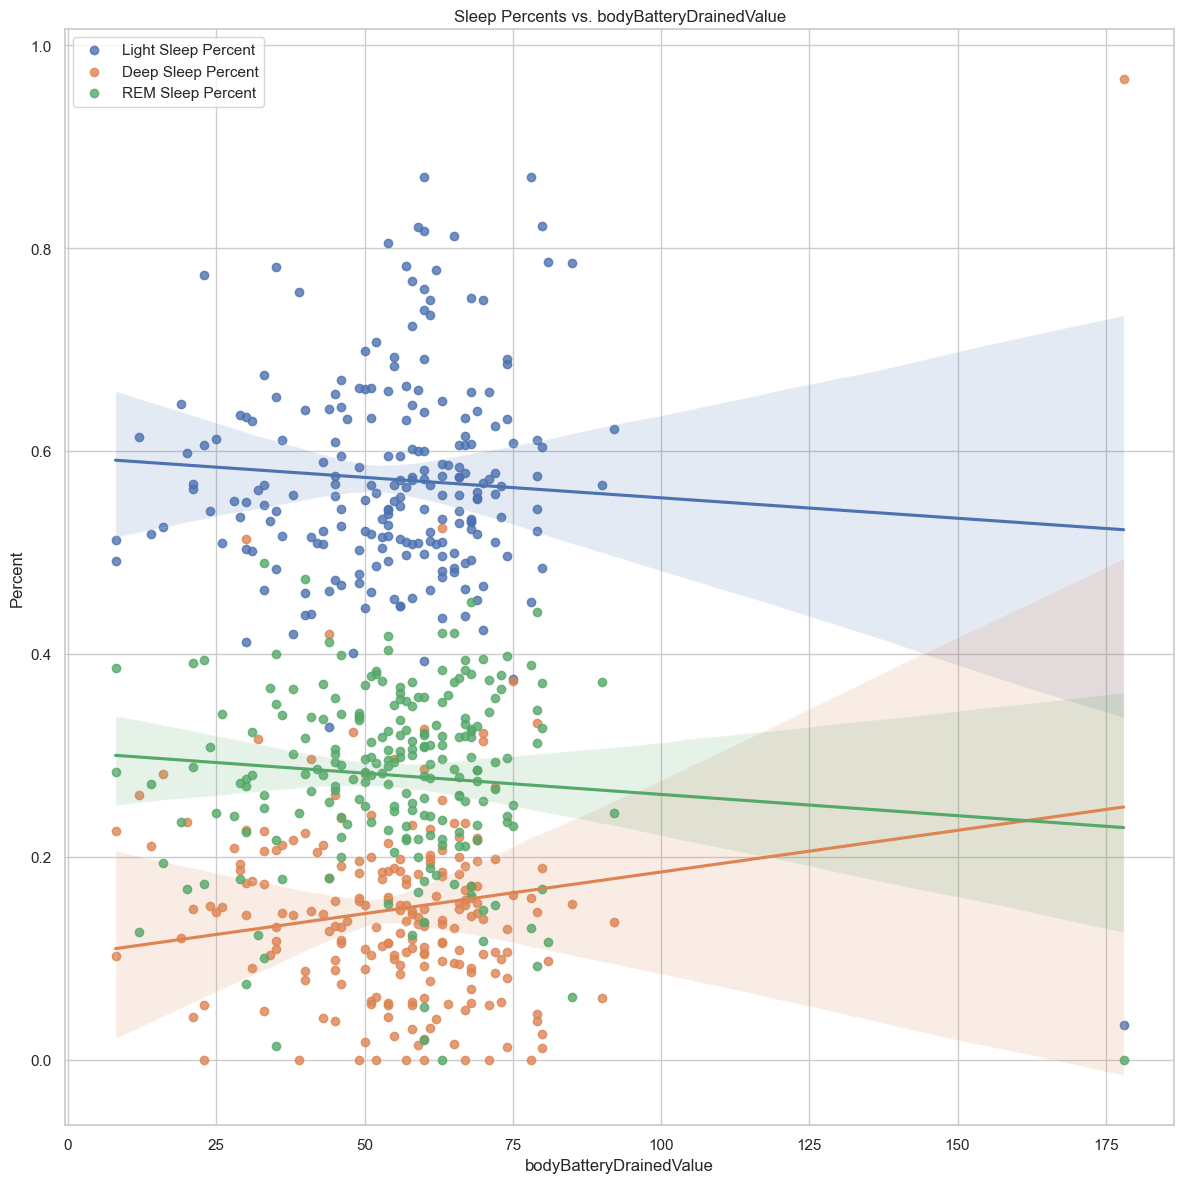

In [62]:
# Sleep vs other variables

def plot_vs_sleep(x: str):
    sns.set_theme(style="whitegrid")
    sns.color_palette("tab10")
    plt.figure(figsize=(12, 12))
    
    sns.regplot(data=df, y="lightSleepPercent", x=x, label="Light Sleep Percent")
    sns.regplot(data=df, y="deepSleepPercent", x=x, label="Deep Sleep Percent")
    sns.regplot(data=df, y="remSleepPercent", x=x, label="REM Sleep Percent")
    
    plt.title("Sleep Percents vs. " + x)
    plt.ylabel("Percent")
    plt.tight_layout()
    plt.legend()
    plt.show()

plot_vs_sleep("sleepTimeHours")
plot_vs_sleep("activeHours")
plot_vs_sleep("sedentaryHours")

plot_vs_sleep("restingHeartRate")
plot_vs_sleep("maxHeartRate")

plot_vs_sleep("averageStressLevel")
plot_vs_sleep("maxStressLevel")
plot_vs_sleep("stressPercentage")
plot_vs_sleep("restStressPercentage")
plot_vs_sleep("highStressPercentage")

plot_vs_sleep("totalSteps")
plot_vs_sleep("totalKilocalories")
plot_vs_sleep("activeKilocalories")

plot_vs_sleep("moderateIntensityMinutes")
plot_vs_sleep("vigorousIntensityMinutes")

plot_vs_sleep("bodyBatteryChargedValue")
plot_vs_sleep("bodyBatteryDrainedValue")